# Job market analysis
### by George Yakushev
04/24/2023

In [2]:
import requests
from time import sleep
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Used Counter to count 'names' and other
from collections import Counter

# Used for iterations through various combinations
from itertools import product

In [3]:
# Special symbol to clear output in loops
LINE_CLEAR = '\x1b[2K'

import tqdm

## Data Scientist

#### Data collection

Interact with database via hh.ru API over set keywords to collect table of vacancies.

In [3]:
# Set hh.ru url
URL = 'https://api.hh.ru/vacancies'

# Set request parameters
params = {
    'text': "Data Scientist",
    'area': 1,
    'page': 0,
    'per_page': 1
}

# Request and transform to df
req = requests.get(URL, params)
data = json.loads(req.content.decode())
df = pd.json_normalize(data['items'])

In [4]:
# Keywords to look for
keywords = ['Data analyst', 'Data scientist', 'Data Engineer']

# Look for maxpage first pages
maxpage = 2

# Iterate through various parameters
for page, text in product(range(0, maxpage), keywords):
    params = {
        'text': text    ,
        'area': 1,
        'page': page,
        'per_page': 100
    }

    # Request data and transform to df
    req = requests.get(URL, params)
    data = json.loads(req.content.decode())
    norm_data = pd.json_normalize(data['items'])

    # Output results of request
    print(end=LINE_CLEAR)
    print('Page: {:<3}/{:<3} Text: {:<20} | Results: {:<5}'.format(page + 1, maxpage, text, len(norm_data)), end='\r')

    # Concat results with df
    df = pd.concat([df, norm_data])

    # Sleep to avoid ddos
    sleep(0.3)

Remove duplicates and unnecessary columns.

In [5]:
# Columns to drop from df
col_to_drop = ['premium', 'has_test',
               'response_letter_required', 'response_url', 'sort_point_distance',
               'published_at', 'archived', 'apply_alternate_url',
               'insider_interview', 'url', 'adv_response_url', 'alternate_url',
               'relations', 'accept_temporary',
               'accept_incomplete_resumes',
               'employer.alternate_url', 'employer.logo_urls.original',
               'employer.logo_urls.90', 'employer.logo_urls.240',
               'employer.vacancies_url', 'snippet.requirement',
               'snippet.responsibility',
               'address.metro.station_name', 'address.metro.line_name',
               'address.metro.station_id', 'address.metro.line_id',
               'address.metro.lat', 'address.metro.lng',
               'employer.logo_urls',
               'insider_interview.id', 'insider_interview.url', 'working_days',
               'working_time_intervals', 'working_time_modes']


# Drop columns and duplicates
df = df.drop_duplicates(['id'])
df = df.drop(columns=col_to_drop)

# Reset index
df = df.reset_index()
df.head()

,index,id,name,department,address,created_at,contacts,schedule,professional_roles,area.id,...,address.lat,address.lng,address.description,address.raw,address.metro,address.metro_stations,address.id,salary,department.id,department.name
0,0,79577718,Data Scientist middle+/Senior,None,None,2023-04-23T09:21:16+0300,None,None,"[{'id': '96', 'name': 'Программист, разработчи...",1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,79103033,Data Analyst (middle),None,None,2023-04-22T13:02:25+0300,None,None,"[{'id': '156', 'name': 'BI-аналитик, аналитик ...",1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,79225796,Data Analyst,None,None,2023-04-21T18:03:29+0300,None,None,"[{'id': '156', 'name': 'BI-аналитик, аналитик ...",1,...,33.670575,-117.78092,NaN,Ирвайн,NaN,[],3210762,NaN,NaN,NaN
3,2,79415326,Data Analyst (Remote),None,None,2023-04-23T16:50:23+0300,None,None,"[{'id': '96', 'name': 'Программист, разработчи...",1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,79532120,Data Analyst (GameDev),None,None,2023-04-22T14:19:19+0300,None,None,"[{'id': '10', 'name': 'Аналитик'}]",1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Collect specific information about each vacancy.

In [6]:
# Load one of the vacancies
vacancy = df['id'].iloc[0]
vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'

req = requests.get(vacancy_url)
vacancy_info = json.loads(req.content.decode())
df_extended_ds = pd.DataFrame([vacancy_info])

df_extended_ds = df_extended_ds.drop(index=0)

In [7]:
# Iter through all found vacancies and load detailed information
idx = 0

# Set of unique id's
set_id = set()
for index, row in df.iterrows():
    idx += 1
    vacancy = df['id'].iloc[index]
    vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'

    # Check for correct processing
    assert not vacancy in set_id
    set_id.add(vacancy)

    # Request and convert to df
    req = requests.get(vacancy_url)
    vacancy_info = json.loads(req.content.decode())
    row_vac = pd.DataFrame([vacancy_info])

    # Concat with df
    df_extended_ds = pd.concat([df_extended_ds, row_vac])

    # Outout progress
    print(end=LINE_CLEAR)
    print('Index: {:<3} from: {:<3}'.format(idx, df.shape[0]), end='\r')

    # Sleep to avoid ddos
    sleep(0.3)

Remove unnecessary columns.

In [8]:
# Columns to drop from df
col_to_drop = ['premium', 'billing_type', 'relations',
               'insider_interview', 'area',
               'type', 'allow_messages',
               'employment', 'contacts',
               'branded_description', 'vacancy_constructor_template',
               'accept_handicapped', 'accept_kids', 'archived', 'response_url',
               'specializations', 'code', 'hidden',
               'quick_responses_allowed', 'driver_license_types',
               'accept_incomplete_resumes', 'published_at', 'created_at',
               'initial_created_at', 'negotiations_url', 'suitable_resumes_url',
               'apply_alternate_url', 'has_test', 'test', 'alternate_url',
               'working_days', 'working_time_intervals', 'working_time_modes',
               'accept_temporary']


# Drop columns and duplicates (if was)
df_extended_ds = df_extended_ds.drop_duplicates(['id'])
df_extended_ds = df_extended_ds.drop(columns=col_to_drop)

# Reset index
df_extended_ds.head()

,id,name,response_letter_required,salary,address,experience,schedule,department,description,key_skills,professional_roles,employer,languages
0,79577718,Data Scientist middle+/Senior,False,"{'from': 250000, 'to': 350000, 'currency': 'RU...",None,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,"<p><strong>Немного о компании, в которую ищем ...","[{'name': 'Spark'}, {'name': 'Python'}, {'name...","[{'id': '96', 'name': 'Программист, разработчи...","{'id': '6116362', 'name': 'Мамаева Ирина Анато...",[]
0,79103033,Data Analyst (middle),True,"{'from': 180000, 'to': 300000, 'currency': 'RU...",None,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'fullDay', 'name': 'Полный день'}",None,<p><strong>Что нужно будет делать: </strong></...,[],"[{'id': '156', 'name': 'BI-аналитик, аналитик ...","{'id': '4976750', 'name': 'Predicto', 'url': '...",[]
0,79225796,Data Analyst,False,"{'from': 230000, 'to': None, 'currency': 'RUR'...","{'city': 'Ирвайн', 'street': None, 'building':...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,"<p>Головной офис компании находится в USA, Cal...","[{'name': 'SQL'}, {'name': 'Python'}, {'name':...","[{'id': '156', 'name': 'BI-аналитик, аналитик ...","{'id': '4354272', 'name': 'Americor Funding In...","[{'id': 'eng', 'name': 'Английский', 'level': ..."
0,79415326,Data Analyst (Remote),False,"{'from': 3000, 'to': 4000, 'currency': 'USD', ...",None,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'remote', 'name': 'Удаленная работа'}",None,<p>Novakid приглашает ведущего продуктового ан...,"[{'name': 'SQL'}, {'name': 'Python'}, {'name':...","[{'id': '96', 'name': 'Программист, разработчи...","{'id': '851716', 'name': 'Novakid Inc', 'url':...","[{'id': 'eng', 'name': 'Английский', 'level': ..."
0,79532120,Data Analyst (GameDev),False,None,None,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'fullDay', 'name': 'Полный день'}",None,<p><strong>Joy Way</strong> — разработчик и па...,"[{'name': 'Python'}, {'name': 'Анализ данных'}...","[{'id': '10', 'name': 'Аналитик'}]","{'id': '4511934', 'name': 'Joy Way', 'url': 'h...",[]


#### Required Skills

Text(0.5, 0.98, 'Pie chart of required skills')

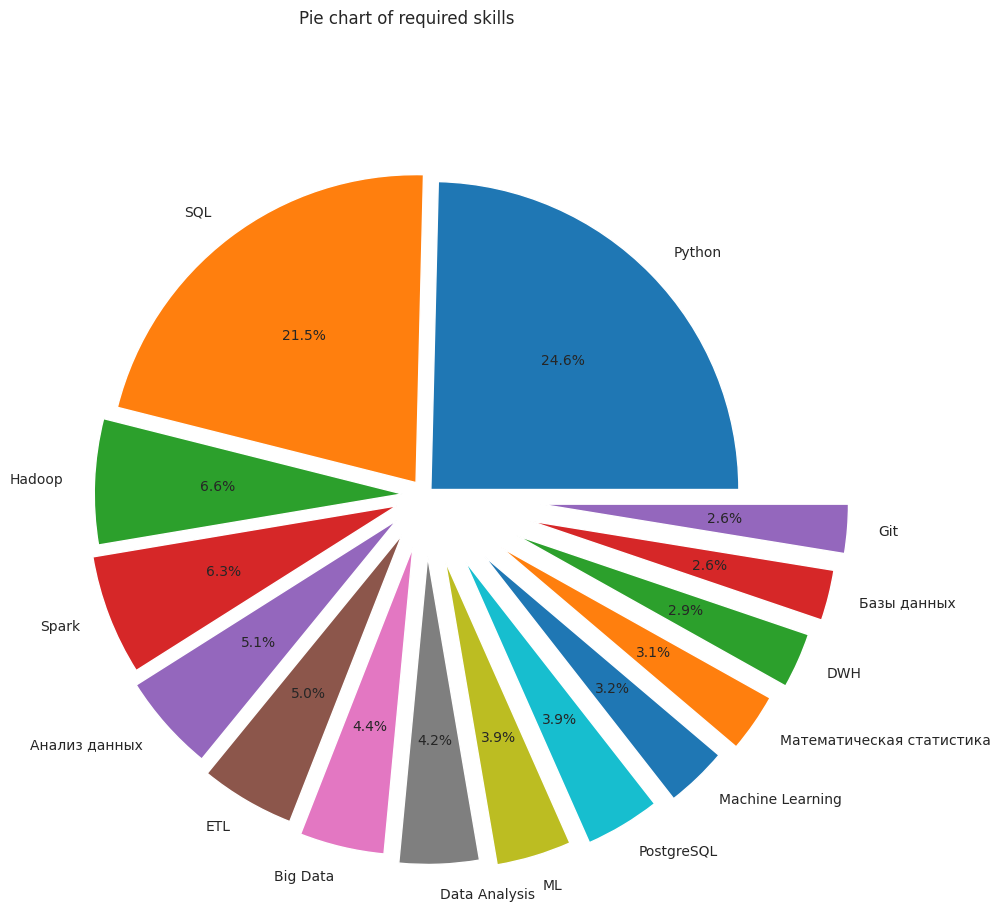

In [9]:
counter_req = Counter()

# Iter through all key skills required and count them
for index, row in df_extended_ds.iterrows():
    list_dict = row['key_skills']
    for dict_req in list_dict:
        counter_req.update({dict_req['name'] : 1})
dict_for_req = dict(counter_req)

# Get 15 most required skills
df_req = pd.Series(dict_for_req).nlargest(15)

# Plot pie chart with key skills required
df_req.plot.pie(autopct='%1.1f%%', figsize=(15, 10), explode=[0.025 * i for i in range(1,16)])
plt.suptitle('Pie chart of required skills')

#### Salary

Salary is stated in 86 from 538 vacancies (15.985130111524164 %)


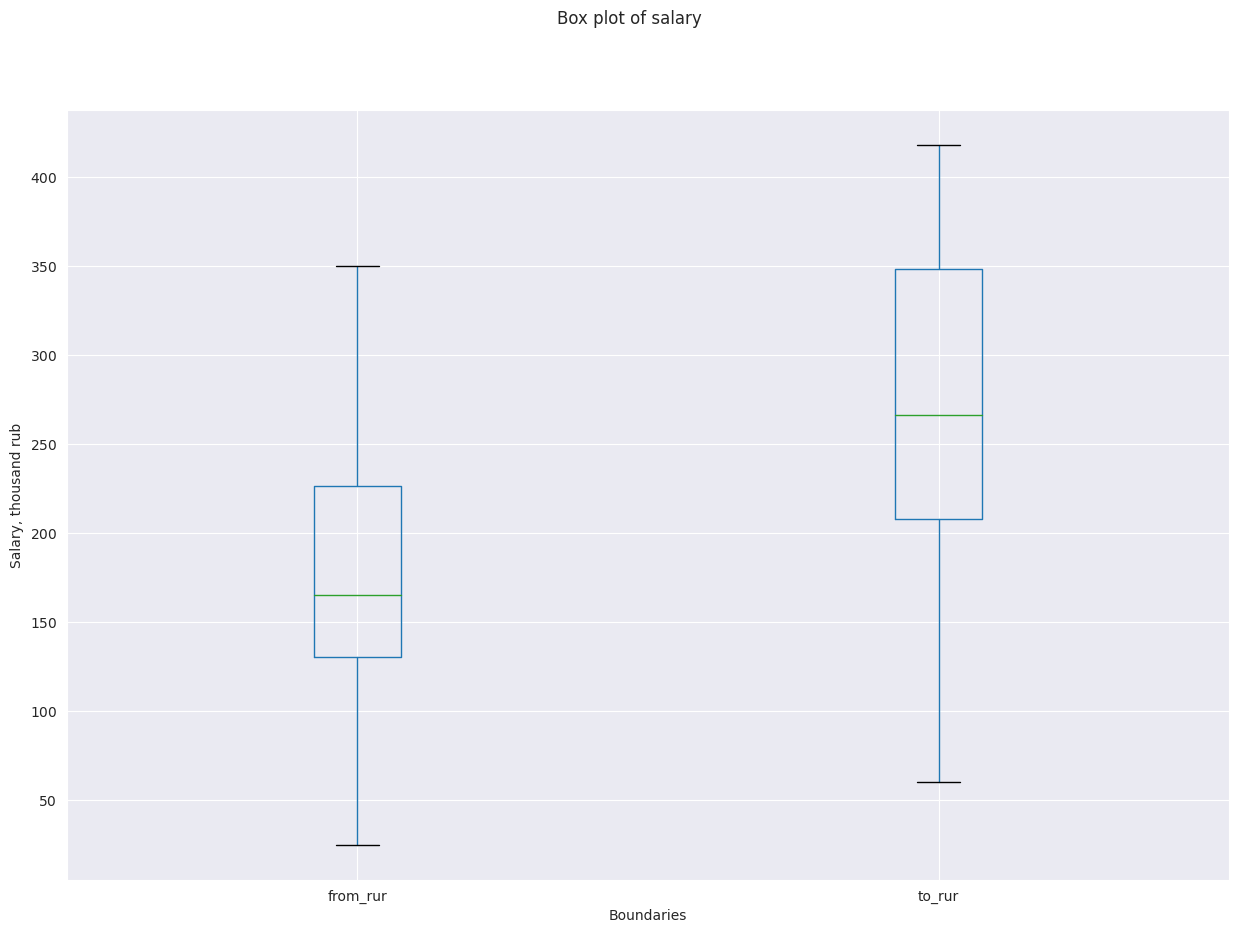

In [10]:
# There is no RUR in the Central European Bank
# from currency_converter import CurrencyConverter
# CurRates = CurrencyConverter()

# Convert to USD
def convert_cur(amount, from_cur):
    coef = 1.
    if from_cur == 'USD':
        coef = 75.47
    if from_cur == 'EUR':
        coef = 80.08
    return amount * coef


def convert_gross(amount, gross):
    coef = 1.
    if gross:
        coef = 0.87
    return amount * coef


# Prepare df with salaries
df_salary = df_extended_ds[['salary']].dropna()
df_salary = df_salary['salary'].apply(pd.Series)

# df_salary['tmp'] = df_salary.apply(lambda x: CurRates.convert(x['from'], x['currency'], 'USD'), axis=1)

# Convert 'from', 'to' columns to USD
df_salary['from_rur'] = df_salary.apply(lambda x: convert_cur(x['from'], x['currency']), axis=1)
df_salary['to_rur'] = df_salary.apply(lambda x: convert_cur(x['to'], x['currency']), axis=1)

df_salary['from_rur'] = df_salary.apply(lambda x: convert_gross(x['from_rur'], x['gross']), axis=1)
df_salary['to_rur'] = df_salary.apply(lambda x: convert_gross(x['to_rur'], x['gross']), axis=1)
df_salary = df_salary.drop(columns=['from', 'to', 'currency', 'gross'])


(df_salary / 1000).boxplot(column=['from_rur', 'to_rur'], showfliers=False, figsize=(15, 10))

# Format ticks
plt.ticklabel_format(style='sci', scilimits=[-4, 4], axis='y', useMathText=True)

# Add a title and axis labels to the plot
plt.suptitle('Box plot of salary')
plt.xlabel('Boundaries')
plt.ylabel('Salary, thousand rub')

print(f'Salary is stated in {df_salary.shape[0]} from {df_extended_ds.shape[0]} vacancies ({100. * df_salary.shape[0] / df_extended_ds.shape[0]} %)')

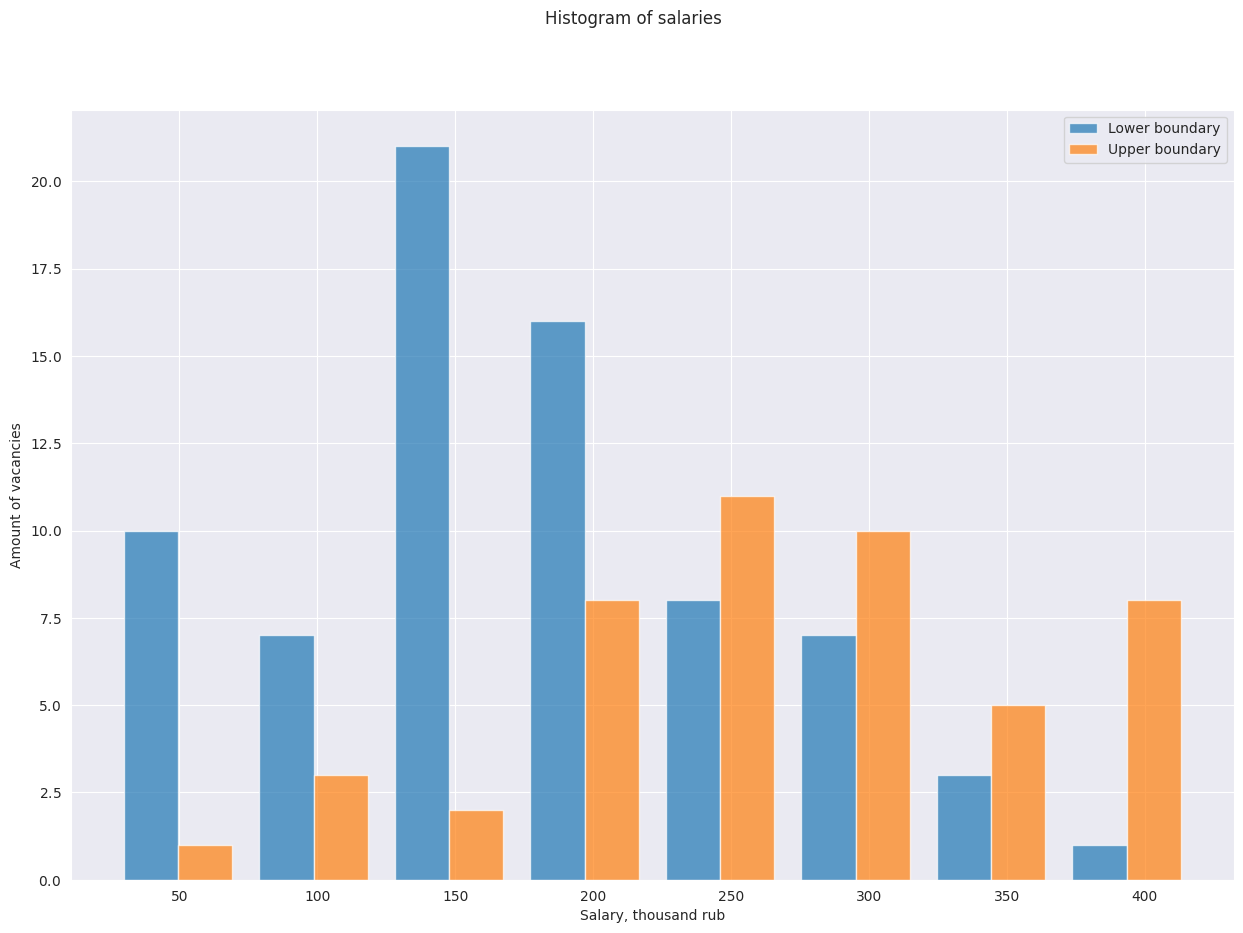

In [11]:
# Plot parameters
plt.rcParams["figure.figsize"] = (15,10)
bins = 8

# Plot
fig, ax = plt.subplots()
ax.hist([(df_salary / 1000)['from_rur'], (df_salary / 1000)['to_rur']], bins=bins, alpha=0.7)
# (df_salary / 1000).hist(column=['from_rur'], figsize=(15, 10), bins=16)

# Format ticks
plt.ticklabel_format(style='sci', scilimits=[-4, 4], axis='y', useMathText=True)

# Add a title and axis labels to the plot
plt.suptitle('Histogram of salaries')
plt.ylabel('Amount of vacancies')
plt.xlabel('Salary, thousand rub')
plt.legend(['Lower boundary', 'Upper boundary'])


### Something else

In [8]:
request_word = "Преподаватель французского языка"
keywords = ['Преподаватель французского языка', 'Французский']

In [9]:
# Set hh.ru url
URL = 'https://api.hh.ru/vacancies'

# Set request parameters
params = {
    'text': request_word,
    'area': 1,
    'page': 0,
    'per_page': 1
}

# Request and transform to df
req = requests.get(URL, params)
data = json.loads(req.content.decode())
df = pd.json_normalize(data['items'])

In [10]:
# Iterate through various parameters
for page, text in product(range(0, 5), keywords):
    params = {
        'text': text    ,
        'area': 1,
        'page': page,
        'per_page': 100
    }

    # Request data and transform to df
    req = requests.get(URL, params)
    data = json.loads(req.content.decode())
    norm_data = pd.json_normalize(data['items'])

    # Output results of request
    print(end=LINE_CLEAR)
    print('Page: {:<3} Text: {:<20} | Results: {:<5}'.format(page, text, len(norm_data)), end='\r')

    # Concat results with df
    df = pd.concat([df, norm_data])

    # Sleep to avoid ddos
    sleep(0.3)

ults: 69   Page: 1   Text: Преподаватель французского языка | Results: 0    Page: 2   Text: Преподаватель французского языка | Results: 0    Page: 3   Text: Преподаватель французского языка | Results: 0    Page: 4   Text: Преподаватель французского языка | Results: 0    

In [11]:
df

,id,premium,name,department,has_test,response_letter_required,response_url,sort_point_distance,published_at,created_at,...,address.metro.line_id,address.metro.lat,address.metro.lng,employer.logo_urls,address,department.id,department.name,insider_interview.id,insider_interview.url,immediate_redirect_url
0,79399177,False,Преподаватель английского языка для дошкольник...,None,True,True,None,None,2023-04-23T13:50:52+0300,2023-04-23T13:50:52+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,79399177,False,Преподаватель английского языка для дошкольник...,None,True,True,None,None,2023-04-23T13:50:52+0300,2023-04-23T13:50:52+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79481574,False,Преподаватель французского языка в школе “Fren...,None,False,False,None,None,2023-04-18T20:20:13+0300,2023-04-18T20:20:13+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79326297,False,Учитель французского языка,None,False,False,None,None,2023-04-14T20:56:40+0300,2023-04-14T20:56:40+0300,...,97,55.765278,37.451667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,79178837,False,Преподаватель французского языка,None,False,False,None,None,2023-04-11T21:46:00+0300,2023-04-11T21:46:00+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,78450509,False,Продавец-консультант ( Rendez-Vous),NaN,False,False,None,None,2023-04-05T10:19:08+0300,2023-04-05T10:19:08+0300,...,3,55.729542,37.470973,NaN,NaN,7465-7465-second,Rendez-Vous. Магазины,NaN,NaN,NaN
96,78688956,False,QA Automation Engineer Middle/Senior (со знани...,NaN,False,False,None,None,2023-04-04T17:57:08+0300,2023-04-04T17:57:08+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,79000656,False,Помощник системного администратора,NaN,False,False,None,None,2023-04-06T14:53:28+0300,2023-04-06T14:53:28+0300,...,7,55.763944,37.562271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,78934004,False,Инженер-механик порта (Африка),NaN,False,False,None,None,2023-04-05T11:42:33+0300,2023-04-05T11:42:33+0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Columns to drop from df
col_to_drop = ['premium', 'has_test',
               'response_letter_required', 'response_url', 'sort_point_distance',
               'published_at', 'archived', 'apply_alternate_url',
               'insider_interview', 'url', 'adv_response_url', 'alternate_url',
               'relations', 'accept_temporary',
               'accept_incomplete_resumes',
               'employer.alternate_url', 'employer.logo_urls.original',
               'employer.logo_urls.90', 'employer.logo_urls.240',
               'employer.vacancies_url', 'snippet.requirement',
               'snippet.responsibility',
               'address.metro.station_name', 'address.metro.line_name',
               'address.metro.station_id', 'address.metro.line_id',
               'address.metro.lat', 'address.metro.lng',
               'employer.logo_urls', 'working_days',
               'working_time_intervals', 'working_time_modes']


# Drop columns and duplicates
df = df.drop_duplicates(['id'])
df = df.drop(columns=col_to_drop)

# Reset index
df = df.reset_index()
df.head()

,index,id,name,department,created_at,contacts,schedule,professional_roles,area.id,area.name,...,experience.name,employment.id,employment.name,salary,address,department.id,department.name,insider_interview.id,insider_interview.url,immediate_redirect_url
0,0,79399177,Преподаватель английского языка для дошкольник...,None,2023-04-23T13:50:52+0300,None,None,"[{'id': '132', 'name': 'Учитель, преподаватель...",1,Москва,...,От 1 года до 3 лет,full,Полная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,79481574,Преподаватель французского языка в школе “Fren...,None,2023-04-18T20:20:13+0300,None,None,"[{'id': '132', 'name': 'Учитель, преподаватель...",1,Москва,...,От 1 года до 3 лет,part,Частичная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,79326297,Учитель французского языка,None,2023-04-14T20:56:40+0300,None,None,"[{'id': '132', 'name': 'Учитель, преподаватель...",1,Москва,...,От 3 до 6 лет,part,Частичная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,79178837,Преподаватель французского языка,None,2023-04-11T21:46:00+0300,None,None,"[{'id': '132', 'name': 'Учитель, преподаватель...",1,Москва,...,Более 6 лет,full,Полная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,78097682,Преподаватель-доцент английского языка в ВУЗ,None,2023-04-21T15:52:54+0300,None,None,"[{'id': '132', 'name': 'Учитель, преподаватель...",1,Москва,...,От 3 до 6 лет,full,Полная занятость,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Load one of the vacancies
vacancy = df['id'].iloc[0]
vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'

req = requests.get(vacancy_url)
vacancy_info = json.loads(req.content.decode())
df_extended_ml = pd.DataFrame([vacancy_info])

df_extended_ml = df_extended_ml.drop(index=0)

In [14]:
# Iter through all found vacancies and load detailed information
idx = 0

# Set of unique id's
set_id = set()
for index, row in df.iterrows():
    idx += 1
    vacancy = df['id'].iloc[index]
    vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'

    # Check for correct processing
    assert not vacancy in set_id
    set_id.add(vacancy)

    # Request and convert to df
    req = requests.get(vacancy_url)
    vacancy_info = json.loads(req.content.decode())
    row_vac = pd.DataFrame([vacancy_info])

    # Concat with df
    df_extended_ml = pd.concat([df_extended_ml, row_vac])

    # Outout progress
    print(end=LINE_CLEAR)
    print('Index: {:<3} from: {:<3}'.format(idx, df.shape[0]), end='\r')

    # Sleep to avoid ddos
    sleep(0.3)

In [15]:
# Columns to drop from df
col_to_drop = ['premium', 'billing_type', 'relations',
               'insider_interview', 'area',
               'type', 'allow_messages',
               'employment', 'contacts',
               'branded_description', 'vacancy_constructor_template',
               'accept_handicapped', 'accept_kids', 'archived', 'response_url',
               'specializations', 'code', 'hidden',
               'quick_responses_allowed', 'driver_license_types',
               'accept_incomplete_resumes', 'published_at', 'created_at',
               'initial_created_at', 'negotiations_url', 'suitable_resumes_url',
               'apply_alternate_url', 'has_test', 'test', 'alternate_url',
               'working_days', 'working_time_intervals', 'working_time_modes',
               'accept_temporary']


# Drop columns and duplicates (if was)
df_extended_ml = df_extended_ml.drop_duplicates(['id'])
df_extended_ml = df_extended_ml.drop(columns=col_to_drop)

# Reset index
df_extended_ml.head()

,id,name,response_letter_required,salary,address,experience,schedule,department,description,key_skills,professional_roles,employer,languages,immediate_redirect_url
0,79399177,Преподаватель английского языка для дошкольник...,True,"{'from': 80000, 'to': None, 'currency': 'RUR',...","{'city': 'Москва', 'street': 'Боровское шоссе'...","{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'flexible', 'name': 'Гибкий график'}",None,<p><strong>ЯЗЫКОВОЙ ЦЕНТР ILS - развитая сеть ...,"[{'name': 'Обучение и развитие'}, {'name': 'Ан...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '3147969', 'name': 'Языковая школа ILS'...","[{'id': 'eng', 'name': 'Английский', 'level': ...",NaN
0,79481574,Преподаватель французского языка в школе “Fren...,False,"{'from': 40000, 'to': 120000, 'currency': 'RUR...","{'city': 'Москва', 'street': 'Тверская улица',...","{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'flexible', 'name': 'Гибкий график'}",None,"<p>Педагог в нашей школе — это больше, чем про...","[{'name': 'Организация учебного процесса'}, {'...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '4838023', 'name': 'Frenchie', 'url': '...","[{'id': 'fra', 'name': 'Французский', 'level':...",NaN
0,79326297,Учитель французского языка,False,None,"{'city': 'Москва', 'street': 'Кременчугская ул...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<p>Кафедра иностранных языков школы &quot;Инте...,[],"[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '9412866', 'name': 'ГБОУ школа Интеллек...",[],NaN
0,79178837,Преподаватель французского языка,False,None,None,"{'id': 'moreThan6', 'name': 'Более 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<strong>Обязанности:</strong> <ul> <li>индивид...,[],"[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '4504411', 'name': 'Фонд Развития Экспе...",[],NaN
0,78097682,Преподаватель-доцент английского языка в ВУЗ,False,None,"{'city': None, 'street': None, 'building': Non...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<p><strong>Московский Международный Университе...,"[{'name': 'Преподаватель'}, {'name': 'доцент'}...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '48553', 'name': 'АНО ВО МОСКОВСКИЙ МЕЖ...","[{'id': 'eng', 'name': 'Английский', 'level': ...",NaN


In [16]:
print('Found {:<3} vacancies'.format(df_extended_ml.shape[0]))

Found 534 vacancies


In [19]:
df_extended_ml

,id,name,response_letter_required,salary,address,experience,schedule,department,description,key_skills,professional_roles,employer,languages,immediate_redirect_url
0,79399177,Преподаватель английского языка для дошкольник...,True,"{'from': 80000, 'to': None, 'currency': 'RUR',...","{'city': 'Москва', 'street': 'Боровское шоссе'...","{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'flexible', 'name': 'Гибкий график'}",None,<p><strong>ЯЗЫКОВОЙ ЦЕНТР ILS - развитая сеть ...,"[{'name': 'Обучение и развитие'}, {'name': 'Ан...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '3147969', 'name': 'Языковая школа ILS'...","[{'id': 'eng', 'name': 'Английский', 'level': ...",NaN
0,79481574,Преподаватель французского языка в школе “Fren...,False,"{'from': 40000, 'to': 120000, 'currency': 'RUR...","{'city': 'Москва', 'street': 'Тверская улица',...","{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'flexible', 'name': 'Гибкий график'}",None,"<p>Педагог в нашей школе — это больше, чем про...","[{'name': 'Организация учебного процесса'}, {'...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '4838023', 'name': 'Frenchie', 'url': '...","[{'id': 'fra', 'name': 'Французский', 'level':...",NaN
0,79326297,Учитель французского языка,False,None,"{'city': 'Москва', 'street': 'Кременчугская ул...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<p>Кафедра иностранных языков школы &quot;Инте...,[],"[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '9412866', 'name': 'ГБОУ школа Интеллек...",[],NaN
0,79178837,Преподаватель французского языка,False,None,None,"{'id': 'moreThan6', 'name': 'Более 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<strong>Обязанности:</strong> <ul> <li>индивид...,[],"[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '4504411', 'name': 'Фонд Развития Экспе...",[],NaN
0,78097682,Преподаватель-доцент английского языка в ВУЗ,False,None,"{'city': None, 'street': None, 'building': Non...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<p><strong>Московский Международный Университе...,"[{'name': 'Преподаватель'}, {'name': 'доцент'}...","[{'id': '132', 'name': 'Учитель, преподаватель...","{'id': '48553', 'name': 'АНО ВО МОСКОВСКИЙ МЕЖ...","[{'id': 'eng', 'name': 'Английский', 'level': ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,78952783,Менеджер по работе с ключевыми клиентами_KAM,False,"{'from': 150000, 'to': None, 'currency': 'RUR'...",None,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<strong>Обязанности:</strong> <ul> <li>Развити...,[],"[{'id': '70', 'name': 'Менеджер по продажам, м...","{'id': '9705572', 'name': 'Тунолио-Рус', 'url'...","[{'id': 'fra', 'name': 'Французский', 'level':...",NaN
0,78450509,Продавец-консультант ( Rendez-Vous),False,"{'from': 75000, 'to': 150000, 'currency': 'RUR...","{'city': 'Москва', 'street': 'Кутузовский прос...","{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'fullDay', 'name': 'Полный день'}","{'id': '7465-7465-second', 'name': 'Rendez-Vou...",<p><strong>О НАС:</strong></p> <p> </p> <p>Бол...,[],"[{'id': '97', 'name': 'Продавец-консультант, п...","{'id': '7465', 'name': 'Rendez-Vous', 'url': '...",[],NaN
0,79000656,Помощник системного администратора,False,"{'from': 60000, 'to': 70000, 'currency': 'RUR'...","{'city': 'Москва', 'street': 'Стрельбищенский ...","{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'flexible', 'name': 'Гибкий график'}",None,<p><strong>Во французскую </strong><strong>DMC...,"[{'name': 'TCP/IP'}, {'name': 'Настройка ПК'},...","[{'id': '113', 'name': 'Системный администрато...","{'id': '41988', 'name': 'Бизнес Трэвел Джоб', ...",[],NaN
0,78934004,Инженер-механик порта (Африка),False,None,None,"{'id': 'moreThan6', 'name': 'Более 6 лет'}","{'id': 'fullDay', 'name': 'Полный день'}",None,<p><strong>ОК РУСАЛ приглашае

Text(0.5, 0.98, 'Pie chart of required skills')

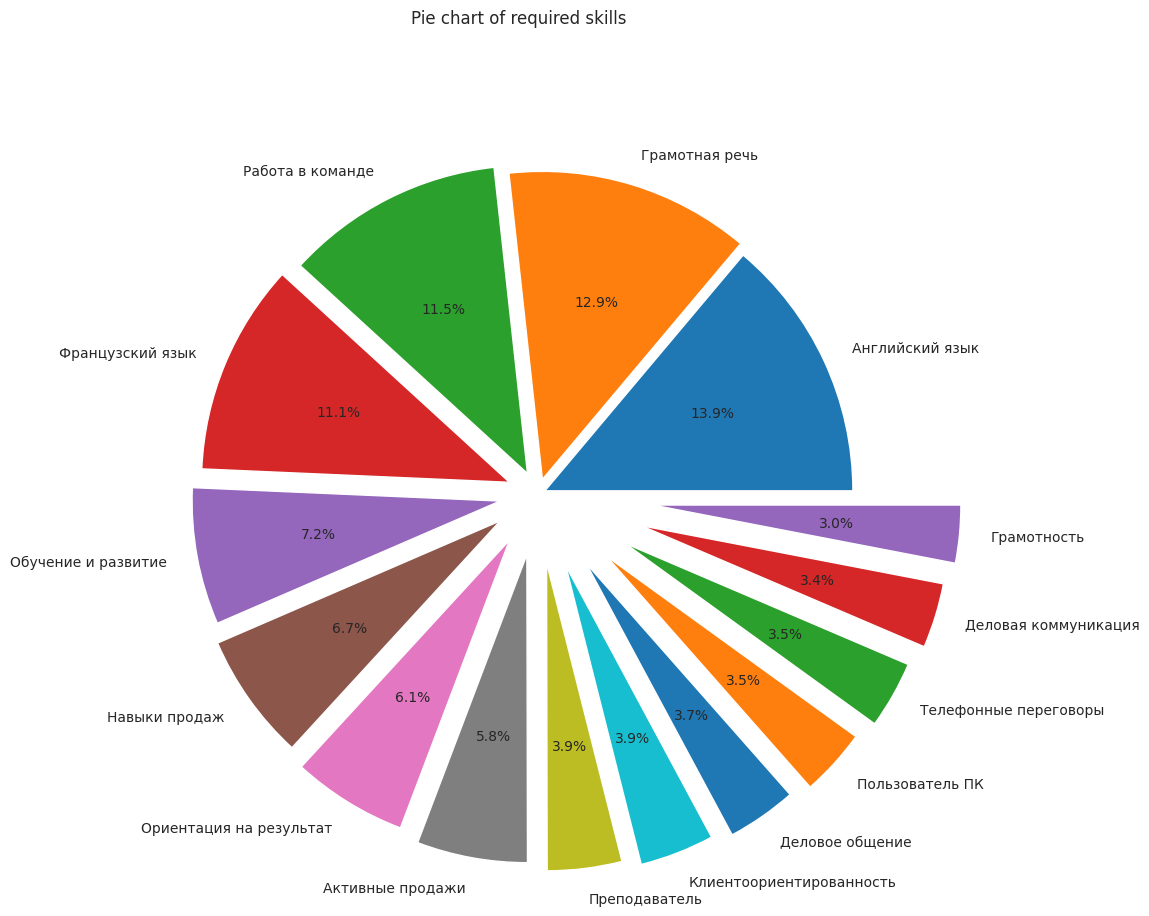

In [17]:
counter_req = Counter()
# Iter through all key skills required and count them
for index, row in df_extended_ml.iterrows():
    list_dict = row['key_skills']
    for dict_req in list_dict:
        counter_req.update({dict_req['name'] : 1})
dict_for_req = dict(counter_req)

# Get 15 most required skills
df_req = pd.Series(dict_for_req).nlargest(15)

# Plot pie chart with key skills required
df_req.plot.pie(autopct='%1.1f%%', figsize=(15, 10), explode=[0.025 * i for i in range(1,16)])
plt.suptitle('Pie chart of required skills')

Salary is stated in 400 of 500 vacancies (80.0 %)


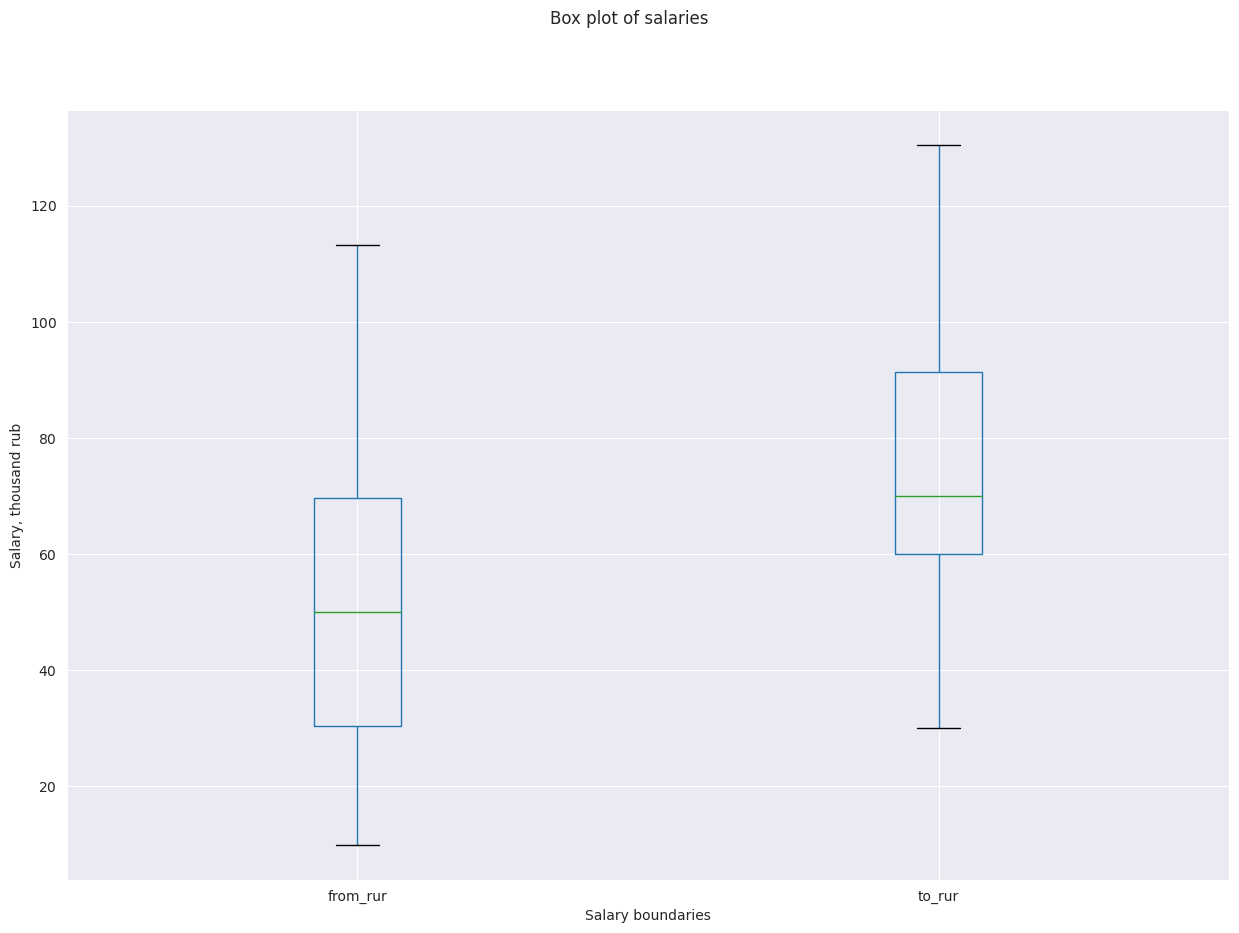

In [26]:
# There is no RUR in the Central European Bank
# from currency_converter import CurrencyConverter
# CurRates = CurrencyConverter()

# Convert to USD
def convert_cur(amount, from_cur):
    coef = 1.
    if from_cur == 'USD':
        coef = 75.47
    if from_cur == 'EUR':
        coef = 80.08
    return amount * coef


def convert_gross(amount, gross):
    coef = 1.
    if gross:
        coef = 0.87
    return amount * coef


# Prepare df with salaries
df_salary = df_extended_ml[['salary']].dropna()
df_salary = df_salary['salary'].apply(pd.Series)

# df_salary['tmp'] = df_salary.apply(lambda x: CurRates.convert(x['from'], x['currency'], 'USD'), axis=1)

# Convert 'from', 'to' columns to USD
df_salary['from_rur'] = df_salary.apply(lambda x: convert_cur(x['from'], x['currency']), axis=1)
df_salary['to_rur'] = df_salary.apply(lambda x: convert_cur(x['to'], x['currency']), axis=1)

df_salary['from_rur'] = df_salary.apply(lambda x: convert_gross(x['from_rur'], x['gross']), axis=1)
df_salary['to_rur'] = df_salary.apply(lambda x: convert_gross(x['to_rur'], x['gross']), axis=1)
df_salary = df_salary.drop(columns=['from', 'to', 'currency', 'gross'])


(df_salary / 1000).boxplot(column=['from_rur', 'to_rur'], showfliers=False, figsize=(15, 10))

# Format ticks
plt.ticklabel_format(style='sci', scilimits=[-4, 4], axis='y', useMathText=True)

# Add a title and axis labels to the plot
plt.suptitle('Box plot of salaries')
plt.xlabel('Salary boundaries')
plt.ylabel('Salary, thousand rub')

print(f'Salary is stated in {df_salary.shape[0]} of {df_extended_ml.shape[0]} vacancies ({100. * df_salary.shape[0] / df_extended_ml.shape[0]} %)')

Exchange rate dates from 03/04/2023

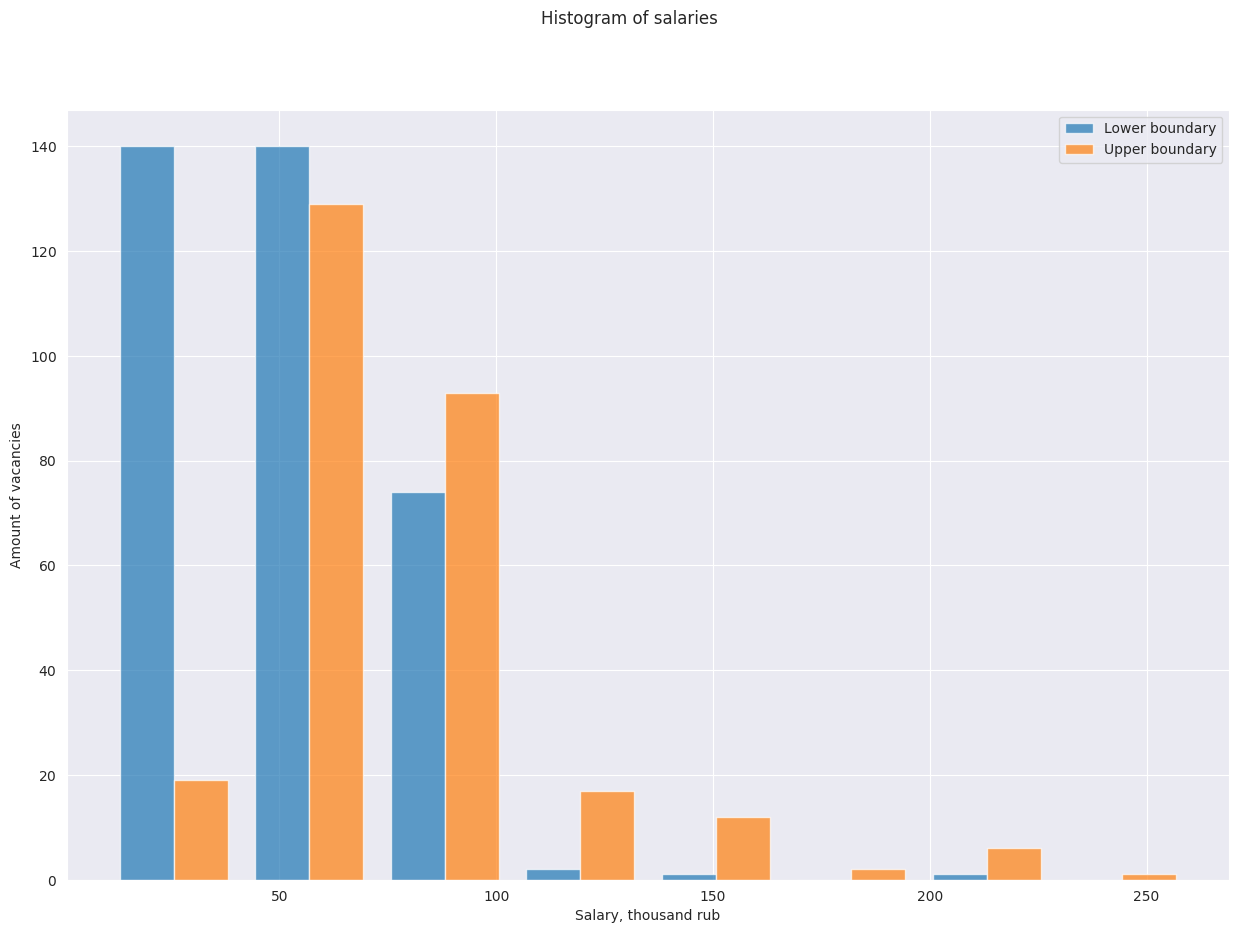

In [27]:
# Plot parameters
plt.rcParams["figure.figsize"] = (15,10)
bins = 8

# Plot
fig, ax = plt.subplots()
ax.hist([(df_salary / 1000)['from_rur'], (df_salary / 1000)['to_rur']], bins=bins, alpha=0.7)
# (df_salary / 1000).hist(column=['from_rur'], figsize=(15, 10), bins=16)

# Format ticks
plt.ticklabel_format(style='sci', scilimits=[-4, 4], axis='y', useMathText=True)

# Add a title and axis labels to the plot
plt.suptitle('Histogram of salaries')
plt.ylabel('Amount of vacancies')
plt.xlabel('Salary, thousand rub')
plt.legend(['Lower boundary', 'Upper boundary'])
